# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

### Carregamento dos dados

In [2]:
df = pd.read_csv('./files/linear_regression_data.csv', header=None)
df.rename(columns={0: 'A', 1: 'B'}, inplace=True)
df

,A,B
0,0.392938,0.086360
1,-0.427721,-0.643872
2,-0.546297,-0.674981
3,0.102630,-0.262892
4,0.438938,0.143177
5,-0.153787,-0.472729
6,0.961528,0.114167
7,0.369659,-0.180323
8,-0.038136,0.011821
9,-0.215765,-0.079865


In [ ]:
# Data
data = df.to_numpy()

# Normalization (Z-score)
mean = np.mean(data, axis=0)
std  = np.std(data, axis=0)

data = (data - mean) / std

X = data[:, :-1]
y = data[:, -1:]

# Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)

Z-Score $$z = \frac{x-\mu}{\sigma}$$

### Questão 1

In [206]:
class BayesianLinearRegression:
    def __init__(self, alpha=10, sigma=1):
        self.alpha = alpha
        self.sigma = sigma

    def fit(self, X, y):
        # Addind Bias Column
        X_ = np.c_[np.ones((X.shape[0],1)), X ] # (D x N)
        N = X_.shape[1] # Bias included

        # Step 1
        m0 = np.linalg.inv(X_.T @ X_) @ X_.T @ y # Regression → Mean: (N x 1)
        S0 = self.alpha**-1 * np.eye(N) # Covavriance Matrix: (N x N)
        
        # Step 1.9999: Parts
        s0xt  = S0 @ X_.T # (N x D)
        s0xtx = s0xt @ X_ # (N x N)
        inv = np.linalg.inv(s0xtx + (self.sigma * np.eye(N))) # (N x N)

        # Step 2
        self.mu = m0 + inv  @ s0xt @ (y - X_ @ m0) # (N x 1)
        self.big_sigma = S0 - inv @ s0xtx @ S0     # (N x N)
        
        # Distribution 
        self.posterior = multivariate_normal(
            mean=self.mu.ravel(), 
            cov=self.big_sigma).pdf
        
    def predict(self, X):
        # Addind Bias Column
        X_ = np.c_[np.ones((X.shape[0],1)), X ] # (D x N)
        D = X_.shape[0] # Bias included
        
        #
        mean = X_ @ self.mu # (D x 1)
        cov  = X_ @ self.big_sigma @ X_.T + self.sigma * np.eye(D)
        
        # Predictive distribution        
        pred_dist = multivariate_normal(mean=mean.ravel(), cov=cov).pdf
        
        return pred_dist(X)
    
    def __str__(self):
        return f'BayesianLinearRegression: \n(alpha → {self.alpha:.2f}) (sigma → {self.sigma:.2f}) \n(coefs → {self.mu.ravel() if hasattr(self, "mu") else None})'

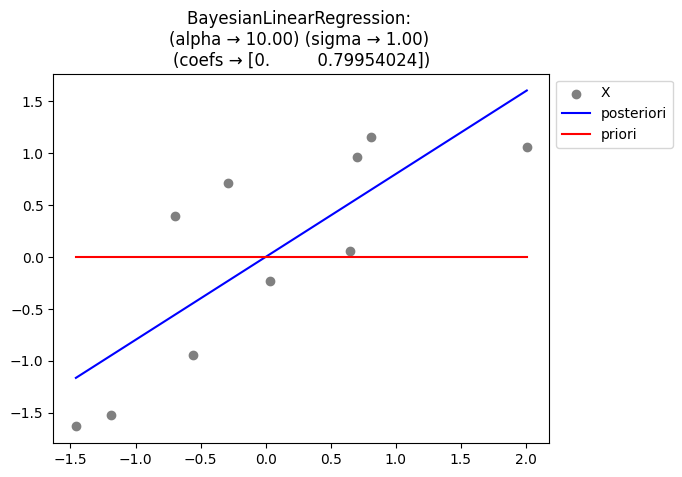

In [ ]:
bregr = BayesianLinearRegression()
bregr.fit(X, y)

# Plot
y_hat = np.c_[np.ones((100 ,1)), np.linspace(X.min(), X.max(), 100)] @ bregr.mu

# Real data
plt.scatter(X, y, color='gray', label="X")

# Lines
plt.plot(
    np.linspace(X.min(), X.max(), 100), y_hat, 
    color='blue', label="posteriori")
plt.plot(
    np.linspace(X.min(), X.max(), 100), [0]*100, 
    color='red', label="priori")

plt.title(bregr)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()